In [2]:
!pip install librosa soundfile numpy pandas scikit-learn matplotlib seaborn tqdm

In [3]:
import os
import numpy as np
import pandas as pd
import soundfile as sf
import librosa
from tqdm import tqdm

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")


In [4]:
# Map RAVDESS filename codes to emotion labels
emotion_map = {
    '01':'neutral','02':'calm','03':'happy','04':'sad',
    '05':'angry','06':'fearful','07':'disgust','08':'surprise'
}

def load_metadata(base_dir):
    paths, labels = [], []
    for root, _, files in os.walk(base_dir):
        for f in files:
            if not f.endswith('.wav'):
                continue
            parts = f.split('-')
            # modality=03 (audio-only), channel=01 (speech)
            if len(parts) >= 3 and parts[0]=='03' and parts[1]=='01':
                paths.append(os.path.join(root, f))
                labels.append(emotion_map.get(parts[2], 'unknown'))
    return pd.DataFrame({'path': paths, 'emotion': labels})

data_dir = '/kaggle/input/audio-dataset'  # adjust if needed
df = load_metadata(data_dir)

print(f"Loaded {len(df)} files")
print(df.emotion.value_counts())


Loaded 1440 files
emotion
surprise    192
disgust     192
fearful     192
sad         192
happy       192
calm        192
angry       192
neutral      96
Name: count, dtype: int64


In [5]:
def extract_feature(fp, n_mfcc=40, n_mels=128):
    # Read audio
    y, sr = sf.read(fp, dtype='float32')
    if y.ndim > 1:           # stereo → mono
        y = np.mean(y, axis=1)

    # Resample if needed (keyword args)
    if sr != 16000:
        y = librosa.resample(y=y, orig_sr=sr, target_sr=16000)
        sr = 16000

    # Compute STFT for chroma
    stft = np.abs(librosa.stft(y, n_fft=1024, hop_length=512))

    # MFCCs (40)
    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc).T, axis=0)
    # Chroma (12)
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sr).T, axis=0)
    # Mel-spectrogram (128)
    mel = np.mean(librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels).T, axis=0)

    # Final feature vector (40 + 12 + 128 = 180 dims)
    return np.hstack([mfcc, chroma, mel])


In [6]:
feature_list = []
for fp in tqdm(df.path, desc="Extracting features"):
    feature_list.append(extract_feature(fp))

X = np.vstack(feature_list)
y = df.emotion.values

print("Feature matrix shape:", X.shape)  # expect (1440, 180)


Extracting features: 100%|██████████| 1440/1440 [01:18<00:00, 18.32it/s]

Feature matrix shape: (1440, 180)


In [7]:
le = LabelEncoder()
y_enc = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, stratify=y_enc, random_state=42
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Label mapping:", dict(zip(le.classes_, le.transform(le.classes_))))


Train shape: (1152, 180) Test shape: (288, 180)
Label mapping: {'angry': 0, 'calm': 1, 'disgust': 2, 'fearful': 3, 'happy': 4, 'neutral': 5, 'sad': 6, 'surprise': 7}


In [8]:
rf = RandomForestClassifier(
    n_estimators=200,
    class_weight='balanced',
    random_state=42
)
rf.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', n_estimators=200,
                       random_state=42)

In [9]:
rf = RandomForestClassifier(
    n_estimators=200,
    class_weight='balanced',
    random_state=42
)
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=200,
                       random_state=42)

Classification Report:
              precision    recall  f1-score   support

       angry       0.67      0.58      0.62        38
        calm       0.65      0.92      0.76        38
     disgust       0.43      0.76      0.55        38
     fearful       0.68      0.44      0.53        39
       happy       0.50      0.36      0.42        39
     neutral       0.82      0.47      0.60        19
         sad       0.55      0.32      0.40        38
    surprise       0.46      0.56      0.51        39

    accuracy                           0.56       288
   macro avg       0.59      0.55      0.55       288
weighted avg       0.58      0.56      0.54       288



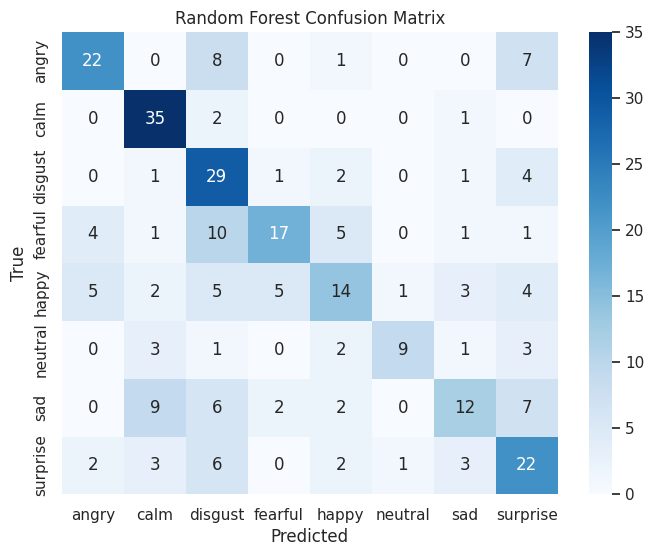

In [10]:
y_pred = rf.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=le.classes_, yticklabels=le.classes_,
            cmap='Blues')
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.show()


In [11]:
# If not already installed
!pip install xgboost

In [12]:
# Imports for XGBoost
from xgboost import XGBClassifier

In [61]:
# 1) Instantiate XGBoost (with multiclass logloss and balanced weights)
xgb = XGBClassifier(
    n_estimators=8800,
    max_depth = 4,
    learning_rate=0.05,
    use_label_encoder=True,
    objective='multi:softprob',
    eval_metric='mlogloss',
    random_state=42
)

# 2) Train
xgb.fit(X_train, y_train)

# 3) Predict & report
y_pred_xgb = xgb.predict(X_test)

In [62]:
# Cell 11: Comprehensive Evaluation with Seaborn Heatmap

import numpy as np
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate(name, y_true, y_pred):
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Plot heatmap
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d',
                xticklabels=le.classes_, yticklabels=le.classes_,
                cmap='Blues')
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()
    
    # Overall accuracy
    overall_acc = accuracy_score(y_true, y_pred)
    print(f"{name} Overall accuracy: {overall_acc*100:.2f}%")
    
    # Per-class accuracy
    per_class_acc = cm.diagonal() / cm.sum(axis=1)
    for cls, acc in zip(le.classes_, per_class_acc):
        print(f"  {cls:>8} accuracy: {acc*100:6.2f}%")
    
    # Macro & per-class F1
    f1_macro = f1_score(y_true, y_pred, average='macro')
    f1_per    = f1_score(y_true, y_pred, average=None)
    print(f"{name} Macro F1: {f1_macro*100:.2f}%")
    for cls, f1 in zip(le.classes_, f1_per):
        print(f"  {cls:>8} F1: {f1*100:6.2f}%")
    
    # Criteria checks
    print("\nCriteria met?")
    print(" • Overall accuracy :", overall_acc)
    print(" • Macro F1 :", f1_macro)
    print(" • All per-class accuracy :", all(per_class_acc) >= 50)
    print("-" * 50)

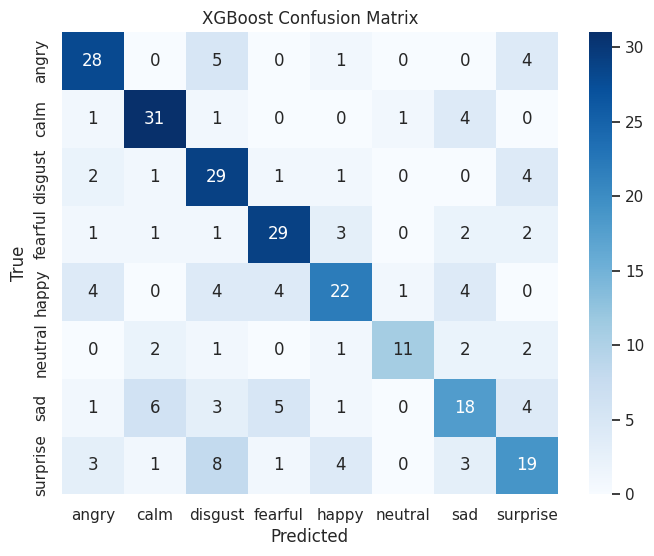

XGBoost Overall accuracy: 64.93%
     angry accuracy:  73.68%
      calm accuracy:  81.58%
   disgust accuracy:  76.32%
   fearful accuracy:  74.36%
     happy accuracy:  56.41%
   neutral accuracy:  57.89%
       sad accuracy:  47.37%
  surprise accuracy:  48.72%
XGBoost Macro F1: 64.88%
     angry F1:  71.79%
      calm F1:  77.50%
   disgust F1:  64.44%
   fearful F1:  73.42%
     happy F1:  61.11%
   neutral F1:  68.75%
       sad F1:  50.70%
  surprise F1:  51.35%

Criteria met?
 • Overall accuracy : 0.6493055555555556
 • Macro F1 : 0.6488421569660984
 • All per-class accuracy : False
--------------------------------------------------


In [63]:
evaluate("XGBoost",      y_test, xgb.predict(X_test))